In [1]:
# Dependencies
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics import F1Score
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

# Our objects
from utils import count_parameters, find_optimal_thresholds, plot_multilabel_conf_matrices, evaluate_with_custom_thresholds
from objects import NormalizeECG, ECGDataset
from models import ECGTransformer, ECGEmbeddings, ECGCombined

In [2]:
# Define device for torch
device = torch.device("cpu")
# MPS for Apple Silicon GPUs
if torch.mps.is_available():
   print("MPS is available")
   device = torch.device("mps")

# CUDA for Nvidia GPUs
if torch.cuda.is_available():
   print("CUDA is available")
   device = torch.device("cuda")
print(device)

MPS is available
mps


# Trainer class

In [21]:
class Trainer:
    def __init__(self, model, device, pos_weights=None, accum_steps=4, checkpoint_interval=256, lr=1e-4,
                 resume_checkpoint=None):
        self.model = model
        self.device = device
        self.accum_steps = accum_steps
        self.checkpoint_interval = checkpoint_interval
        
        # Initialize essential components
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.f1 = F1Score(task='multilabel', num_labels=self.model.num_classes, average=None)
        self.loss = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device) if pos_weights is not None else None)
        self.accum_loss = 0.0
        self.loss_history = []
        self.acc_history = []
        self.batch_count = 0
        self.start_epoch = 0
        self.start_batch = 0
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='max',              # maximize F1
            factor=0.5,              # halve the LR
            patience=2,              # after 2 stagnating checkpoints
            threshold=0.001,
            verbose=True
        )

        if resume_checkpoint:
            self._load_checkpoint(resume_checkpoint)

    def _load_checkpoint(self, checkpoint_path):
        """Load training state from checkpoint"""
        checkpoint = torch.load(checkpoint_path, map_location=self.device, weights_only=False)
        
        # Essential parameters
        self.model.load_state_dict(checkpoint['model_state'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state'])
        
        # Training progress
        self.loss_history = checkpoint['loss_history']
        self.acc_history = checkpoint['acc_history']
        self.batch_count = checkpoint.get('batch_count', 0)
        self.start_epoch = checkpoint['epoch']
        self.start_batch = checkpoint.get('batch', 0) + 1
        
        # Configurations
        self.checkpoint_interval = checkpoint.get('checkpoint_interval', 
                                                 self.checkpoint_interval)
        
        print(f"Loading epoch {self.start_epoch} batch {self.start_batch}")

    def train(self, train_dataloader, test_dataloader, num_epochs, save_path="training_progress"):
        os.makedirs(save_path, exist_ok=True)
        self.model.train()
        
        for epoch in range(self.start_epoch, num_epochs):
            for batch_idx, (inputs, labels) in enumerate(train_dataloader):
                if batch_idx < self.start_batch:
                    continue
                
                
                # Forward pass
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.loss(outputs, labels) / self.accum_steps

                # Backward pass
                loss.backward()

                # Every batch
                self.accum_loss += loss.item()
                self.batch_count += 1
                
                # Every accum_steps
                if (batch_idx + 1) % self.accum_steps == 0:
                    self._update_parameters()
                    
                    # Save loss
                    avg_loss = self.accum_loss
                    self.loss_history.append([self.batch_count, avg_loss])
                    self.accum_loss = 0.0

                    print(f"Epoch {epoch+1}/{num_epochs} | Batch {batch_idx+1}/{len(train_dataloader)} | "
                        f"Avg Loss: {avg_loss:.4f}")

                # Every checkpoint_interval
                if self.batch_count % self.checkpoint_interval == 0:
                    acc = self.evaluate(test_dataloader)
                    self.acc_history.append([self.batch_count, acc])

                    # Scheduler step based on F1 macro average
                    avg_f1 = np.mean(acc["f1_per_class"])
                    self.scheduler.step(avg_f1)

                    self._save_checkpoint(save_path, epoch, batch_idx)
                
                # Sanity checks
                if self.batch_count % 128 == 0:
                    probs = torch.sigmoid(outputs)
                    print("Example probs:", probs[0].detach().cpu().numpy())
                    print("Ground truth :", labels[0].cpu().numpy())
                
                del inputs, labels, outputs, loss
            self.start_batch = 0

    def evaluate(self, dataloader):
        self.model.eval()
        total_samples = 0
        num_classes = self.model.num_classes
        mismatches_per_class = torch.zeros(num_classes, device=self.device)

        all_probs = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                probs = torch.sigmoid(outputs).cpu().numpy()
                
                all_probs.append(probs)
                all_labels.append(labels.cpu().numpy())
                total_samples += inputs.size(0)

        # Stack across batches
        all_probs = np.vstack(all_probs)
        all_labels = np.vstack(all_labels)

        # Find optimal thresholds
        optimal_thresholds = find_optimal_thresholds(all_labels, all_probs)

        # Apply thresholds
        preds = (all_probs >= optimal_thresholds).astype(int)

        # Metrics
        f1_score_per_class = f1_score(all_labels, preds, average=None, zero_division=0)
        hamming_loss_per_class = np.mean(np.not_equal(preds, all_labels), axis=0)
        overall_hamming_loss = np.mean(np.not_equal(preds, all_labels))

        precision_per_class = precision_score(all_labels, preds, average=None, zero_division=0)
        recall_per_class = recall_score(all_labels, preds, average=None, zero_division=0)

        conf_matrices = multilabel_confusion_matrix(all_labels, preds)
        tp = conf_matrices[:, 1, 1].tolist()
        fp = conf_matrices[:, 0, 1].tolist()
        fn = conf_matrices[:, 1, 0].tolist()
        tn = conf_matrices[:, 0, 0].tolist()

        return {
            "f1_per_class": f1_score_per_class,
            "overall_hamming_loss": overall_hamming_loss,
            "hamming_loss_per_class": hamming_loss_per_class,
            "precision": precision_per_class,
            "recall": recall_per_class,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
            "optimal_thresholds": optimal_thresholds  # Save this if you want to reuse
        }   
    
    def _update_parameters(self):
        """Update model parameters with gradient clipping"""
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()
        self.optimizer.zero_grad()

    def _save_checkpoint(self, path, epoch, batch_idx):
        """Save model and training state"""
        checkpoint = {
            'epoch': epoch,
            'batch': batch_idx,
            'batch_count': self.batch_count,
            'checkpoint_interval': self.checkpoint_interval,
            'model_state': self.model.state_dict(),
            'optimizer_state': self.optimizer.state_dict(),
            'loss_history': self.loss_history,
            'acc_history': self.acc_history
        }
        
        torch.save(checkpoint, f"{path}/checkpoint_ep{epoch}_b{batch_idx}.pt")
        print(f"\nCheckpoint saved at epoch {epoch+1} batch {batch_idx+1}")

        np.save(f"{path}/loss_history.npy", np.array(self.loss_history))
        np.save(f"{path}/acc_history.npy", np.array(self.acc_history))


# Training

## Settings

In [4]:
# Meta
diagnoses = "data/diagnoses_balanced.csv"
data_path = "data/ecg_clipped"
save_path = "training_progress/clipped_balanced3"
checkpoint_interval = 512

# Training Hyperparameters
add_pos_weights = True
normalize = True
batch_size = 4
accum_steps = 8         # Updates every accum_steps batches
starting_lr = 5e-4      # For resuming, set lr (could be lower) at the resume cell below

# Model Embeddings parameters
d_input = 12
d_model = 128

# Model Transformer parameters
nhead = 4
num_encoder_layers = 2
dim_feedforward = 256

## Load Dataset

In [5]:
ecg_dataset = ECGDataset(path=data_path, diagnoses=diagnoses, transform=NormalizeECG() if normalize else None)
pos_weights = ecg_dataset.get_pos_weights() if add_pos_weights else None
num_classes = ecg_dataset.get_num_classes()

train_dataset, test_dataset, val_dataset = random_split(
                                            ecg_dataset, [len(ecg_dataset) - 1000, 500, 500])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Number of classes: 5


## Load Model

In [6]:
model = ECGCombined(d_input=d_input, d_model=d_model, num_classes=num_classes, nhead=nhead, num_encoder_layers=num_encoder_layers, dim_feedforward=dim_feedforward).to(device)
print(model)
print("Number of parameters in embeddings")
count_parameters(model.embedding_model)
print("Number of parameters in transformer")
count_parameters(model.transformer)

ECGCombined(
  (embedding_model): ECGEmbeddings(
    (conv_layers): ModuleList(
      (0): Conv1d(12, 24, kernel_size=(1,), stride=(1,), padding=same)
      (1): Conv1d(24, 48, kernel_size=(1,), stride=(1,), padding=same)
      (2): Conv1d(48, 96, kernel_size=(1,), stride=(1,), padding=same)
      (3): Conv1d(96, 128, kernel_size=(1,), stride=(1,), padding=same)
    )
    (activation): ReLU()
  )
  (transformer): ECGTransformer(
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNor

## Start Training from 0:

In [ ]:
trainer = Trainer(model, device, accum_steps=accum_steps, lr=starting_lr, pos_weights=pos_weights, checkpoint_interval=checkpoint_interval)
trainer.train(train_dataloader, test_dataloader, num_epochs=10, save_path=save_path)

## Resume Training from a checkpoint:

In [ ]:
resume_from = f"{save_path}/checkpoint_ep7_b4773.pt"    # Set checkpoint here
resume_lr = 1e-4                                        # Set a lower lr if needed

trainer = Trainer(model, device, accum_steps=accum_steps, lr=starting_lr, pos_weights=pos_weights, checkpoint_interval=checkpoint_interval, resume_checkpoint=resume_from)
trainer.train(train_dataloader, test_dataloader, num_epochs=10, save_path=save_path)

# Plot accuracy and loss

In [7]:
loss_history = np.load(f'{save_path}/loss_history.npy', allow_pickle=True)  # Load loss history
acc_history = np.load(f'{save_path}/acc_history.npy', allow_pickle=True)

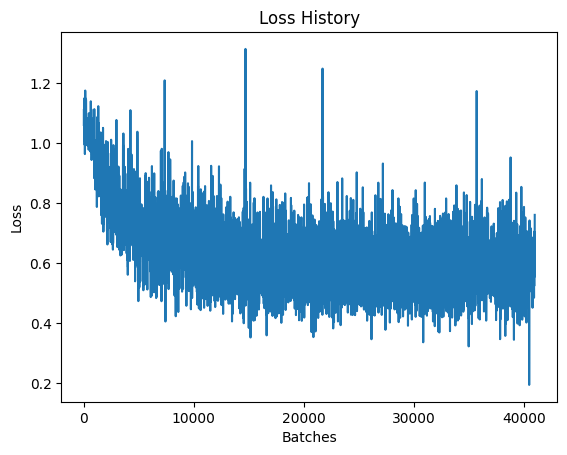

In [8]:
# Plot loss history
x = [epoch[0] for epoch in loss_history]
y = [epoch[1] for epoch in loss_history]
plt.plot(x, y, label='Loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Loss History')
plt.show()

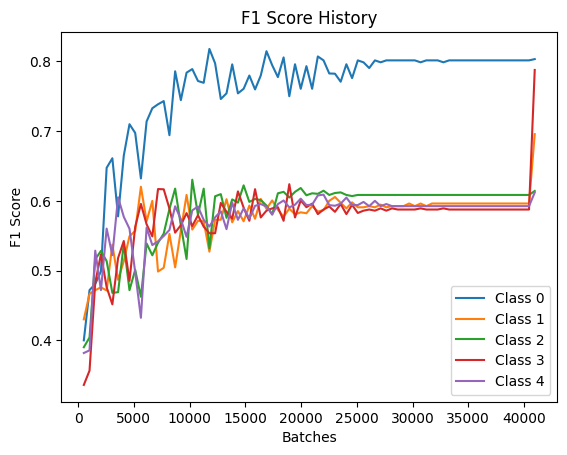

In [9]:
# Plot F1 score history
x = [epoch[0] for epoch in acc_history]
y = [epoch[1]['f1_per_class'] for epoch in acc_history]

plt.plot(x, y)
plt.xlabel('Batches')
plt.legend([f'Class {i}' for i in range(len(y[0]))])
plt.ylabel('F1 Score')
plt.title('F1 Score History')
plt.show()

Text(0.5, 1.0, 'Hamming Loss per class')

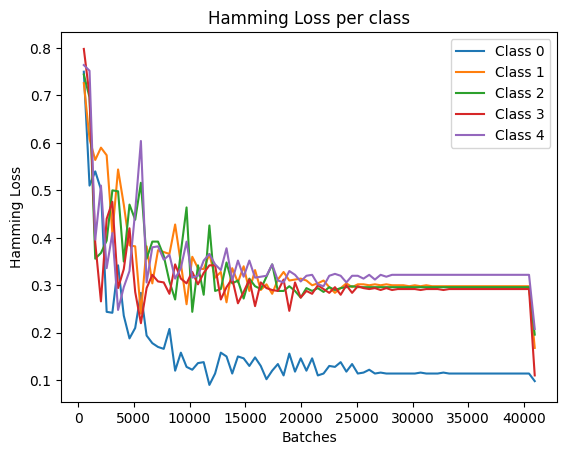

In [10]:
# Plot Hamming Loss
x = [epoch[0] for epoch in acc_history]
y = [epoch[1]['hamming_loss_per_class'] for epoch in acc_history]

plt.plot(x, y)
plt.legend([f'Class {i}' for i in range(len(y[0]))])
plt.xlabel('Batches')
plt.ylabel('Hamming Loss')
#plt.yscale('log')
plt.title('Hamming Loss per class')

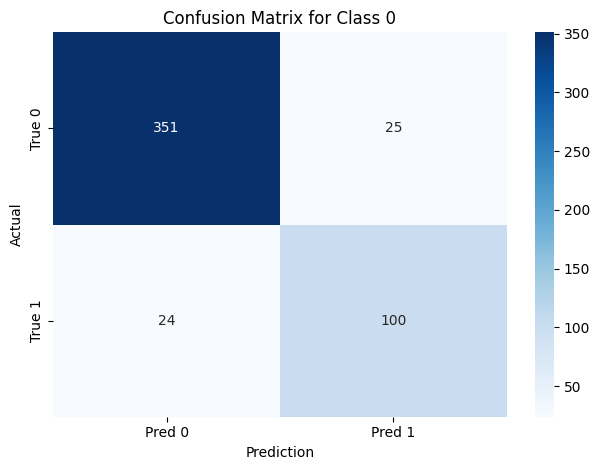

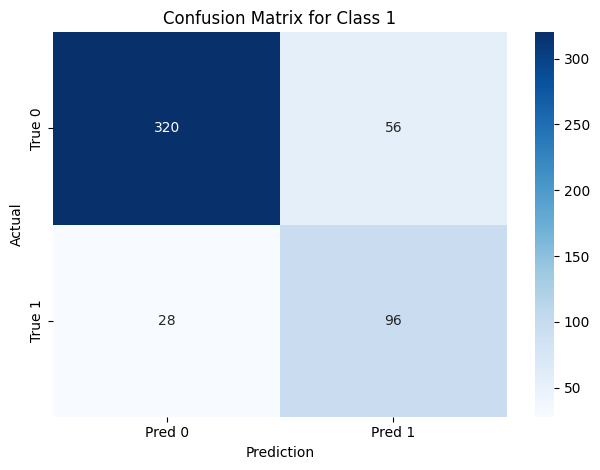

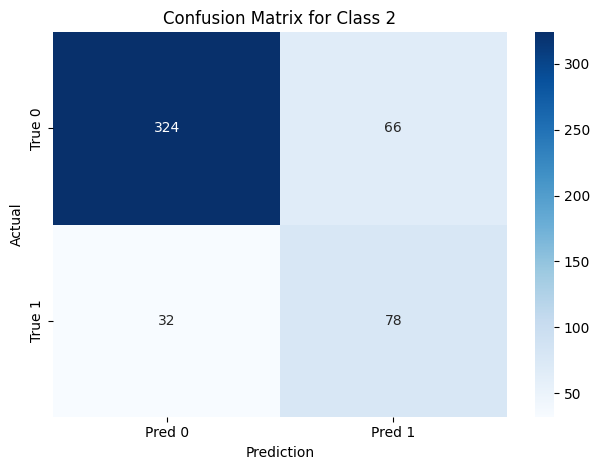

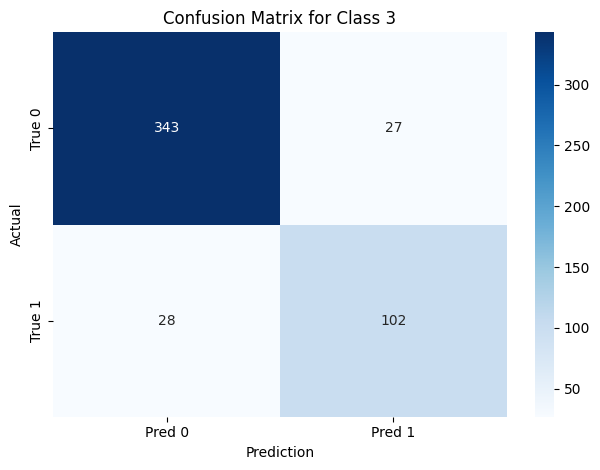

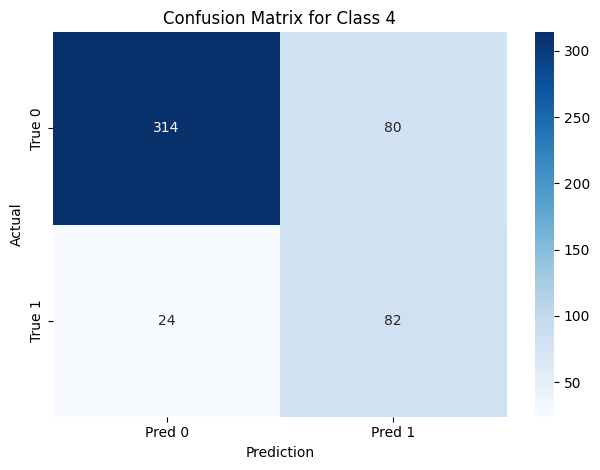

In [11]:
# Plot Confusion Matrices
# Choose the latest evaluation (last checkpoint)
last_eval = acc_history[-1][1]  # acc_history = [batch_count, eval_dict]

for i in range(5):
   # Extract TP, FP, FN, TN
   tp = last_eval["tp"][i]
   fp = last_eval["fp"][i]
   fn = last_eval["fn"][i]
   tn = last_eval["tn"][i]

   # Create confusion matrix
   cm = np.array([[tn, fp],
                  [fn, tp]])

   # Plot
   sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
               xticklabels=["Pred 0", "Pred 1"],
               yticklabels=["True 0", "True 1"])
   plt.title(f"Confusion Matrix for Class {i}")
   plt.xlabel("Prediction")
   plt.ylabel("Actual")
   plt.tight_layout()
   plt.show()

In [ ]:
for key, value in acc_history[-1][-1].items():
    print(f"{key}: {value}")

# Threshold Tuning

In [23]:
resume_from = f"{save_path}/checkpoint_ep7_b4773.pt"

model = ECGCombined(d_input=d_input, d_model=d_model, num_classes=num_classes, nhead=nhead, num_encoder_layers=num_encoder_layers, dim_feedforward=dim_feedforward).to(device)
trainer = Trainer(model, device, accum_steps=accum_steps, lr=starting_lr, pos_weights=pos_weights, checkpoint_interval=checkpoint_interval, resume_checkpoint=resume_from)
# Final model evaluation
results = trainer.evaluate(val_dataloader)

# Save optimal thresholds for reuse
np.save(f"{save_path}/thresholds.npy", results["optimal_thresholds"])
print("Opitmal Thresholds:", results["optimal_thresholds"])

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:59: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Loading epoch 7 batch 4774
Opitmal Thresholds: [0.75 0.7  0.55 0.75 0.5 ]


In [24]:
# Load final model checkpoint
resume_from = f"{save_path}/checkpoint_ep7_b4773.pt"  # Replace with best one
model = ECGCombined(d_input=d_input, d_model=d_model, num_classes=num_classes, nhead=nhead, num_encoder_layers=num_encoder_layers, dim_feedforward=dim_feedforward).to(device)
trainer = Trainer(model, device, pos_weights=pos_weights, resume_checkpoint=resume_from)

# Load optimal thresholds
thresholds = np.load(f"{save_path}/thresholds.npy")

# Evaluate with custom thresholds

evaluate_with_custom_thresholds(trainer, test_dataloader, thresholds)


Loading epoch 7 batch 4774


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:59: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


F1 score with tuned thresholds: [0.8365019  0.65587045 0.62271062 0.73127753 0.60627178]


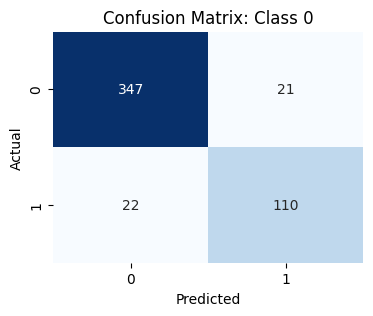

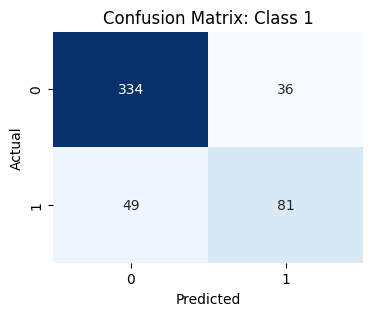

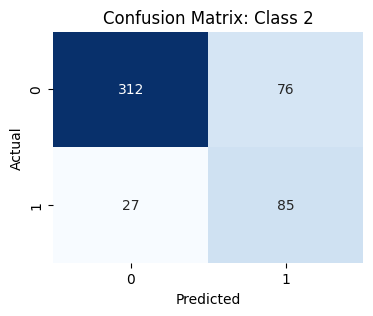

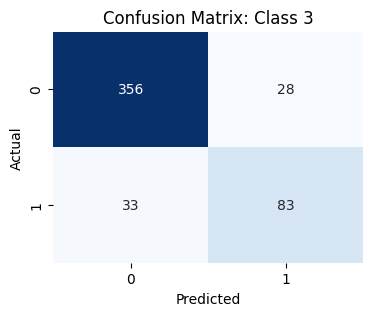

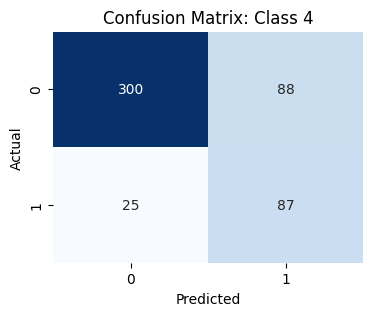

In [22]:
results = trainer.evaluate(test_dataloader)
thresholds = np.load(f"{save_path}/thresholds.npy")

# Redo predictions using new thresholds
all_probs, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs).cpu().numpy()
        all_probs.append(probs)
        all_labels.append(labels.cpu().numpy())

all_probs = np.vstack(all_probs)
all_labels = np.vstack(all_labels)
y_pred = (all_probs >= thresholds).astype(int)

# Plot confusion matrices
plot_multilabel_conf_matrices(all_labels, y_pred)